<a href="https://colab.research.google.com/github/Anouska-A/MyProjects/blob/main/Stock_Prediction_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**J COMPONENT REPORT**

STOCK PREDICTION ANALYSIS WITH SENTIMENT ANALYSIS AND HISTORICAL STOCK DATA

ANOUSKA ACHARYA, 20BCE1629

In [ ]:
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install 'scikit-learn==0.24.0' # Have to use this version of scikit-learn, for mean_absolute_error

import pandas as pd
import numpy as np
from numpy import concatenate
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

from textblob import TextBlob

from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import nltk
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

A date time parser has been defined as a function so that we can later merge both the datasets on the given date colums which must have the same format. A crawler has also been built so that we are able to extract the news headlines related to the stocks upon which we can use the sentiment analyzer to get the polarity scores as attributes.

In [ ]:
class datetime_parser:

	def __init__(self):
		self.date = ''
		self.time = ''

	def parsing(self,dateinfo):
		dateinfo = [x.replace('\xa0\xa0', '') for x in dateinfo.split(' ')]
		if len(dateinfo) > 1:
			self.date = dateinfo[0]
			self.time = dateinfo[1]
		else:
			self.time = dateinfo[0]

		return datetime.strptime(self.date + " " + self.time, "%b-%d-%y %I:%M%p")

def stock_ticker_crawler(limit=10):
	html = requests.get('https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/').text
	soup = BeautifulSoup(html, 'html.parser')
	companyName = [x.get_text(strip=True) for x in soup.find_all('div', {'class': 'company-name'})][:limit]
	companyCode = [x.get_text(strip=True) for x in soup.find_all('div', {'class': 'company-code'})][:limit]

	return [{'company-code': x, 'company-name': y} for x, y in zip(companyCode, companyName)]

def news_headlines(ticker):
	url = f'https://finviz.com/quote.ashx?t={ticker}'
	req = requests.get(url, headers={'user-agent': 'nlp_bot'}).text
	html = BeautifulSoup(req, 'html.parser')
	headline = html.find(id='news-table')
	# print(headline)
	return headline
df_prices = pd.read_csv('https://raw.githubusercontent.com/harinu123/data/main/BSESN.csv')

def preprocessing(headline):
	dParser = datetime_parser()
	table = []
	# table = [x.a.text for x in headline.find_all('tr')]
	for x in headline.findAll('tr'):
		if(x.a and x.a.text):
			table.append(x.a.text)

	date_info = [dParser.parsing(x.td.text) for x in headline.find_all('tr')]

	headlines = [{"news-title": x, "Date": y} for x, y in zip(table, date_info)]

	return headlines

def convert_to_DF(stock, news):
	stock_info = []
	for x in news:
		stock_info.append({**stock,**x})

	return pd.DataFrame(stock_info)


def sentiment_analysis(title):
	return sia().polarity_scores(title)['compound']

def data_visualization(df):

	plt.figure(figsize=(10,8), dpi =80)
	df['date_trunc'] = pd.to_datetime(df['Date']).dt.date
	avg_df= df[['company-code', 'date_trunc', 'scores']].groupby(['company-code', 'date_trunc']).mean().unstack()

	avg_df = avg_df.xs('scores', axis="columns").transpose()
	#avg_df.to_excel('process.xlsx')
	avg_df.plot(kind='bar')
	plt.show()


In [ ]:
cols = ['Date','Category','News']
df_news = pd.read_csv('https://raw.githubusercontent.com/harinu123/data/main/india-news-headlines.csv', names=cols)
df_news.head()
stock_info = stock_ticker_crawler(limit=3)
stock_info

[{'company-code': 'AAPL', 'company-name': 'Apple'},
 {'company-code': 'MSFT', 'company-name': 'Microsoft'},
 {'company-code': 'GOOG', 'company-name': 'Alphabet (Google)'}]

In [ ]:
news_headline_info = [preprocessing(news_headlines(x['company-code'])) for x in stock_info]

In [ ]:
stock_data = [convert_to_DF(x, y) for x, y in zip(stock_info, news_headline_info)]
stock_data = pd.concat(stock_data)

## VADER Sentiment Analysis calculating for polarity scores based on title
stock_data['scores'] = stock_data['news-title'].apply(sentiment_analysis)

#stock_data.to_excel('final_data.xlsx')
print(stock_data)

   company-code       company-name  \
0          AAPL              Apple   
1          AAPL              Apple   
2          AAPL              Apple   
3          AAPL              Apple   
4          AAPL              Apple   
..          ...                ...   
95         GOOG  Alphabet (Google)   
96         GOOG  Alphabet (Google)   
97         GOOG  Alphabet (Google)   
98         GOOG  Alphabet (Google)   
99         GOOG  Alphabet (Google)   

                                           news-title                Date  \
0   Best Dow Jones Stocks To Buy And Watch In Apri... 2023-04-13 09:59:00   
1    Activision Bulls Wager on More Deal-Driven Gains 2023-04-13 09:37:00   
2   Apple India iPhone Output Soars to $7 Billion ... 2023-04-13 09:33:00   
3   Apple Goes Big On India: Triples iPhone Produc... 2023-04-13 09:20:00   
4   UPDATE 1-Apple to use only recycled cobalt in ... 2023-04-13 08:34:00   
..                                                ...                 ...   
95  

<Figure size 800x640 with 0 Axes>

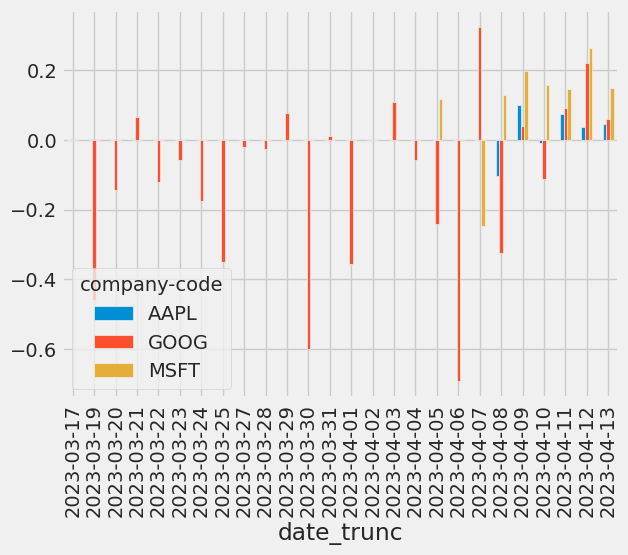

In [ ]:
data_visualization(stock_data)
cols = ['Date','Category','News']
df_news = df_news.dropna(axis = 0, how ='any')

In [ ]:
#t=stock_data[stock_data['company-code'].values == 'AAPL']

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Adding both together

In [ ]:
# Dropping 0 values, and the Category column as we don't require this for our analysis.
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)

In [ ]:
# Converting 'Date' columns from both our dataframes to type datetime
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-14,41883.089844,41994.261719,41770.898438,41952.628906,41952.628906,14100.0
1,2020-01-15,41969.859375,41969.859375,41648.109375,41872.730469,41872.730469,6100.0
2,2020-01-16,41924.738281,42059.449219,41812.281250,41932.558594,41932.558594,6600.0
3,2020-01-17,41929.019531,42063.929688,41850.289063,41945.371094,41945.371094,9500.0
4,2020-01-20,42263.000000,42273.871094,41503.371094,41528.910156,41528.910156,7500.0
...,...,...,...,...,...,...,...
247,2021-01-08,48464.910156,48854.339844,48365.578125,48782.511719,48782.511719,22200.0
248,2021-01-11,49252.308594,49303.789063,48956.378906,49269.320313,49269.320313,21200.0
249,2021-01-12,49228.261719,49569.140625,49079.570313,49517.109375,49517.109375,12700.0
250,2021-01-13,49763.929688,49795.191406,49073.851563,49492.320313,49492.320313,27200.0


In [ ]:
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x))
df_news = df_news.drop_duplicates()
df_news.reset_index(inplace = True, drop = True)
stock_data

,company-code,company-name,news-title,Date,scores,date_trunc
0,AAPL,Apple,Best Dow Jones Stocks To Buy And Watch In Apri...,2023-04-13 09:59:00,0.6369,2023-04-13
1,AAPL,Apple,Activision Bulls Wager on More Deal-Driven Gains,2023-04-13 09:37:00,0.3976,2023-04-13
2,AAPL,Apple,Apple India iPhone Output Soars to $7 Billion ...,2023-04-13 09:33:00,0.0000,2023-04-13
3,AAPL,Apple,Apple Goes Big On India: Triples iPhone Produc...,2023-04-13 09:20:00,0.0000,2023-04-13
4,AAPL,Apple,UPDATE 1-Apple to use only recycled cobalt in ...,2023-04-13 08:34:00,0.0000,2023-04-13
...,...,...,...,...,...,...
95,GOOG,Alphabet (Google),YouTube TV raises its monthly subscription pri...,2023-03-17 17:05:00,0.0000,2023-03-17
96,GOOG,Alphabet (Google),Analyst Report: Alphabet Inc.,2023-03-17 17:05:00,0.0000,2023-03-17
97,GOOG,Alphabet (Google),Heres Whats Buzzing at SXSW 2023,2023-03-17 13:21:00,0.0000,2023-03-17
98,GOOG,Alphabet (Google),YouTube to Raise Prices on TV Offering,2023-03-17 10:18:00,0.0000,2023-03-17


In [ ]:
import re
# Cleaning headlines
c = []

for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    print(i)
    news=' '.join(news)
    c.append(news)
    # news = [word for word in news if word not in set(stopwords.words('english'))]
    # print(news)
    # news = []
    # for w in news: news.append(ps.stem(w))
    # print(news)
    # news=' '.join(news)
    # print(news)
    # c.append(news)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181


In [ ]:
df_news['News'] = pd.Series(c)
df_news

,Date,News
0,2020-01-01,bone clling cold wavecontinu sweep state gain ...
1,2020-01-02,horoscop today januari read predict ari tauru ...
2,2020-01-03,bank holiday mazya navryac bayko updat januari...
3,2020-01-04,mamta mohanda play nurs lalbagh tolli celeb op...
4,2020-01-05,home beauti blue live diet induc sound sleep y...
...,...,...
177,2020-06-26,contain zone resid slam gh price charg veget v...
178,2020-06-27,like wont let toxic relationsp food major ravi...
179,2020-06-28,atanu ghosh plan rewrit old script make relev ...
180,2020-06-29,hot stylish bikini look katrina kaif anna eden...


## Calculating Subjectivity and Polarity scores using TextBlob module:

In [ ]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [ ]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2020-01-01,bone clling cold wavecontinu sweep state gain ...,0.407322,0.040349
1,2020-01-02,horoscop today januari read predict ari tauru ...,0.410638,0.078692
2,2020-01-03,bank holiday mazya navryac bayko updat januari...,0.370711,0.085875
3,2020-01-04,mamta mohanda play nurs lalbagh tolli celeb op...,0.389496,0.126830
4,2020-01-05,home beauti blue live diet induc sound sleep y...,0.350895,0.093071
...,...,...,...,...
177,2020-06-26,contain zone resid slam gh price charg veget v...,0.324106,0.066983
178,2020-06-27,like wont let toxic relationsp food major ravi...,0.371791,0.063043
179,2020-06-28,atanu ghosh plan rewrit old script make relev ...,0.368076,0.054104
180,2020-06-29,hot stylish bikini look katrina kaif anna eden...,0.370906,0.061918


## Carrying out Sentimental Analysis on the News Headlines:

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.5 MB/s eta 0:00:00


In [ ]:
#Adding sentiment score to df_news
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2020-01-01,bone clling cold wavecontinu sweep state gain ...,0.407322,0.040349,-0.9998,0.150,0.775,0.075
1,2020-01-02,horoscop today januari read predict ari tauru ...,0.410638,0.078692,-0.9998,0.154,0.765,0.082
2,2020-01-03,bank holiday mazya navryac bayko updat januari...,0.370711,0.085875,-0.9993,0.121,0.789,0.090
3,2020-01-04,mamta mohanda play nurs lalbagh tolli celeb op...,0.389496,0.126830,-0.9998,0.146,0.776,0.079
4,2020-01-05,home beauti blue live diet induc sound sleep y...,0.350895,0.093071,-0.9998,0.155,0.771,0.074
...,...,...,...,...,...,...,...,...
177,2020-06-26,contain zone resid slam gh price charg veget v...,0.324106,0.066983,-0.9998,0.141,0.787,0.072
178,2020-06-27,like wont let toxic relationsp food major ravi...,0.371791,0.063043,-0.9998,0.138,0.790,0.072
179,2020-06-28,atanu ghosh plan rewrit old script make relev ...,0.368076,0.054104,-0.9998,0.134,0.798,0.068
180,2020-06-29,hot stylish bikini look katrina kaif anna eden...,0.370906,0.061918,-0.9998,0.129,0.800,0.070



## We will use our **Sentimental Analysis findings** along with the historical prices data for predicting stock prices **using Multivariate Time Series Forecasting**:



In [ ]:
# Merging our findings (the updated News dataframe) with the Prices dataframe
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
print(df_prices)
df_merge.drop('Date', axis = 1, inplace=True)
df_merge.drop('News', axis=1, inplace=True)
print(df_merge.columns)
print(len(df_merge))
print(len(df_prices))
print(len(df_news))

          Date          Open          High           Low         Close  \
0   2020-01-14  41883.089844  41994.261719  41770.898438  41952.628906   
1   2020-01-15  41969.859375  41969.859375  41648.109375  41872.730469   
2   2020-01-16  41924.738281  42059.449219  41812.281250  41932.558594   
3   2020-01-17  41929.019531  42063.929688  41850.289063  41945.371094   
4   2020-01-20  42263.000000  42273.871094  41503.371094  41528.910156   
..         ...           ...           ...           ...           ...   
247 2021-01-08  48464.910156  48854.339844  48365.578125  48782.511719   
248 2021-01-11  49252.308594  49303.789063  48956.378906  49269.320313   
249 2021-01-12  49228.261719  49569.140625  49079.570313  49517.109375   
250 2021-01-13  49763.929688  49795.191406  49073.851563  49492.320313   
251 2021-01-14  49432.828125  49663.578125  49182.371094  49584.160156   

        Adj Close   Volume  
0    41952.628906  14100.0  
1    41872.730469   6100.0  
2    41932.558594   6600

In [ ]:
# getting our data series ready for Multivariate Time Series Forecasting
from pandas import DataFrame as df
from pandas import concat
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df1 = df(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df1.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df1.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
# scale our data for optimal performance
values = df_merge.values
print(df_merge)
print(values)
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[12,13,14,16,17,18,19,20,21,22,23]], axis=1, inplace=True)
print(reframed.columns)

             Open          High           Low         Close     Adj Close  \
0    41883.089844  41994.261719  41770.898438  41952.628906  41952.628906   
1    41969.859375  41969.859375  41648.109375  41872.730469  41872.730469   
2    41924.738281  42059.449219  41812.281250  41932.558594  41932.558594   
3    41929.019531  42063.929688  41850.289063  41945.371094  41945.371094   
4    42263.000000  42273.871094  41503.371094  41528.910156  41528.910156   
..            ...           ...           ...           ...           ...   
108  35679.738281  35706.550781  34794.929688  34868.980469  34868.980469   
109  34525.390625  35081.609375  34499.781250  34842.101563  34842.101563   
110  35144.781250  35254.878906  34910.339844  35171.269531  35171.269531   
111  34926.949219  35032.359375  34662.058594  34961.519531  34961.519531   
112  35168.300781  35233.910156  34812.800781  34915.800781  34915.800781   

      Volume  Subjectivity  Polarity  Compound  Negative  Neutral  Positive

### Building a **LSTM** **(Long Short Term Memory)** Model to predict Stock Prices:

In [ ]:
# split into train and test sets
values = reframed.values
print((values).shape)
n_train_hours = 90
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(112, 13)
(90, 1, 12) (90,) (22, 1, 12) (22,)


In [ ]:
# design the network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
2/2 - 7s - loss: 0.6298 - val_loss: 0.5579 - 7s/epoch - 4s/step
Epoch 2/50
2/2 - 0s - loss: 0.5963 - val_loss: 0.5265 - 45ms/epoch - 22ms/step
Epoch 3/50
2/2 - 0s - loss: 0.5636 - val_loss: 0.4952 - 51ms/epoch - 26ms/step
Epoch 4/50
2/2 - 0s - loss: 0.5314 - val_loss: 0.4640 - 48ms/epoch - 24ms/step
Epoch 5/50
2/2 - 0s - loss: 0.4996 - val_loss: 0.4328 - 59ms/epoch - 30ms/step
Epoch 6/50
2/2 - 0s - loss: 0.4678 - val_loss: 0.4014 - 60ms/epoch - 30ms/step
Epoch 7/50
2/2 - 0s - loss: 0.4363 - val_loss: 0.3699 - 48ms/epoch - 24ms/step
Epoch 8/50
2/2 - 0s - loss: 0.4053 - val_loss: 0.3381 - 46ms/epoch - 23ms/step
Epoch 9/50
2/2 - 0s - loss: 0.3743 - val_loss: 0.3059 - 52ms/epoch - 26ms/step
Epoch 10/50
2/2 - 0s - loss: 0.3438 - val_loss: 0.2733 - 49ms/epoch - 25ms/step
Epoch 11/50
2/2 - 0s - loss: 0.3140 - val_loss: 0.2403 - 60ms/epoch - 30ms/step
Epoch 12/50
2/2 - 0s - loss: 0.2849 - val_loss: 0.2069 - 46ms/epoch - 23ms/step
Epoch 13/50
2/2 - 0s - loss: 0.2580 - val_loss: 0.173

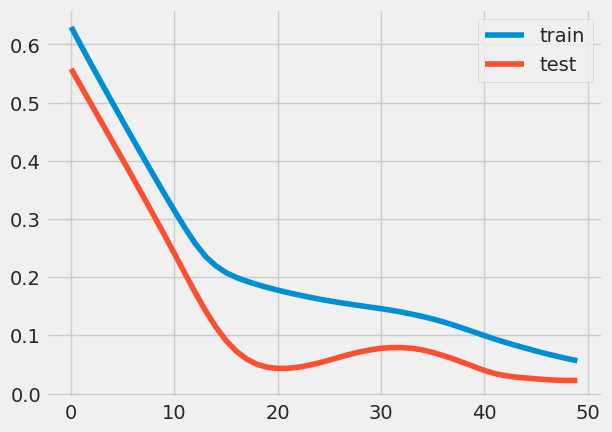

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### **Testing** the LSTM Model with the test data and calculating **RMSE(Root Mean Square Error)**:

Any transform operations applied to the series also require a similar inverse transform to be applied on the predictions. This is required so that the resulting calculated performance measures are in the same scale as the output variable and can be compared to classical forecasting methods. So we do that before making the predictions and finding the rmse

In [ ]:
# make a prediction
print(test_X.shape)
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[2]))
print(test_X.shape)
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


(22, 1, 12)
(22, 1, 12)
1/1 [==============================] - 0s 351ms/step
Test RMSE: 464.906


###Inference

A good fit is identified by a training and validation loss that decreases to a point of stability with a minimal gap between the two final loss values. From the train and test loss plots we can see the lines going almost parallely and the loss difference is low so we can theorize that the training occurs properly as there is no overfitting or underfitting.